In [0]:
import os
from dotenv import load_dotenv
import platform
import warnings
from tqdm.auto import tqdm
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import transbigdata as tbd
import datetime
import random
# import dask
# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
import math
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# sns.set_context('notebook')
# sns.set_theme(style="ticks", palette="pastel")
# plt.style.use(['grid'])

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
tbd.set_mapboxtoken(os.getenv('MAPBOX_TOKEN'))

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# GPS数据
data = pd.read_csv(r'E:\taxi_data\gps_data\gps_1\20140803_train.txt', 
                   header=None,
                   names=['出租车ID', '纬度', '经度', '载客状态', '时间点'])
data['纬度'] = data['纬度'].astype(float)
data['经度'] = data['经度'].astype(float)
data['时间点'] = pd.to_datetime(data['时间点'])
data['小时'] = data['时间点'].dt.hour
data['时间段'] = pd.cut(data['小时'], bins=[0, 6, 12, 18, 24], labels=['凌晨', '上午', '下午', '晚上'])
data

Set mapboxtoken success


,出租车ID,纬度,经度,载客状态,时间点,小时,时间段
0,1,30.624806,104.136604,1,2014-08-03 21:18:46,21,晚上
1,1,30.624809,104.136612,1,2014-08-03 21:18:15,21,晚上
2,1,30.624811,104.136587,1,2014-08-03 21:20:17,21,晚上
3,1,30.624811,104.136596,1,2014-08-03 21:19:16,21,晚上
4,1,30.624811,104.136619,1,2014-08-03 21:17:44,21,晚上
...,...,...,...,...,...,...,...
53045402,13605,30.732042,103.998304,1,2014-08-03 11:24:41,11,上午
53045403,13605,30.732262,103.997677,1,2014-08-03 11:28:58,11,上午
53045404,13605,30.732322,103.997589,1,2014-08-03 11:25:21,11,上午
53045405,13605,30.732406,103.997811,1,2014-08-03 11:25:12,11,上午


In [1]:
lat_min, lat_max, lon_min, lon_max = data['纬度'].min(), data['纬度'].max(), data['经度'].min(), data['经度'].max() 

In [2]:
lat_min, lat_max, lon_min, lon_max

(30.290675, 31.032468, 103.269638, 104.609693)

In [3]:
dd = data.sample(20000)
# 定义栅格化函数
def create_grid(data, lat_bins=100, lon_bins=100):
    lat_min, lat_max = data['纬度'].min(), data['纬度'].max()
    lon_min, lon_max = data['经度'].min(), data['经度'].max()
    
    lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    print(lat_edges[-1]-lat_edges[-2])
    lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    print(lon_edges[-1]-lon_edges[-2])
    
    data['lat_bin'] = pd.cut(data['纬度'], bins=lat_edges, labels=False, include_lowest=True)
    data['lon_bin'] = pd.cut(data['经度'], bins=lon_edges, labels=False, include_lowest=True)
    
    return data, lat_edges, lon_edges

# 栅格化数据
data, lat_edges, lon_edges = create_grid(data)

# 统计每个网格的数据点数量
grid_counts = data.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# 选择前13个最多出租车数量的栅格
top_13_grids = grid_counts.nlargest(13, 'count')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 12))

# 出租车位置分布图
ax1.scatter(dd['经度'], dd['纬度'], alpha=0.2, s=5)
ax1.set_title('出租车位置分布')
ax1.set_xlabel('经度')
ax1.set_ylabel('纬度')

# 绘制栅格
for lat in lat_edges:
    ax1.axhline(y=lat, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
for lon in lon_edges:
    ax1.axvline(x=lon, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# 绘制前13个最多出租车数量的栅格，用红色标记
for _, grid in top_13_grids.iterrows():
    lat = lat_edges[grid['lat_bin']]
    lon = lon_edges[grid['lon_bin']]
    ax1.add_patch(plt.Rectangle((lon, lat), 
                                lon_edges[1]-lon_edges[0], 
                                lat_edges[1]-lat_edges[0], 
                                fill=False, 
                                edgecolor='red', 
                                linewidth=2))

# 每小时数据点数量图
hourly_counts = data.groupby('小时').size()
hourly_counts.plot(kind='line', ax=ax2)
ax2.set_title('每小时数据点数量')
ax2.set_xlabel('小时')
ax2.set_ylabel('数据点数量')

plt.tight_layout()
plt.savefig('map.pdf', bbox_inches='tight', dpi=1000)

0.007417929999999018
0.013400550000000067


In [4]:
top_13_grids

,lat_bin,lon_bin,count
1987,49,59,918484
1933,48,59,889976
1934,48,60,745274
1988,49,60,732036
1880,47,60,622832
2238,54,59,585937
2088,51,58,585826
1881,47,61,584909
1331,37,51,550680
1878,47,58,549073


In [5]:
# Filter data for taxi ID '2' and POIs in top 13 grids
filtered_data = data[data['出租车ID'] == 2]
filtered_data = filtered_data[filtered_data.apply(lambda row: (row['lat_bin'], row['lon_bin']) in zip(top_13_grids['lat_bin'], top_13_grids['lon_bin']), axis=1)]

# If the output is still truncated, you can increase the display options
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Now display the data again
print(filtered_data.sort_values(['时间点']).head(100).to_string())

      出租车ID         纬度          经度  载客状态                 时间点  小时 时间段  lat_bin  lon_bin
4254      2  30.647703  104.022304     1 2014-08-03 11:36:01  11  上午       48       56
4309      2  30.648777  104.022311     1 2014-08-03 11:36:11  11  上午       48       56
4338      2  30.649769  104.022259     1 2014-08-03 11:36:21  11  上午       48       56
4354      2  30.650148  104.022250     1 2014-08-03 11:36:31  11  上午       48       56
4357      2  30.650228  104.022254     1 2014-08-03 11:36:41  11  上午       48       56
4373      2  30.650682  104.022335     1 2014-08-03 11:36:51  11  上午       48       56
4433      2  30.651396  104.022524     1 2014-08-03 11:37:01  11  上午       48       56
4500      2  30.652037  104.022463     1 2014-08-03 11:37:11  11  上午       48       56
4647      2  30.653286  104.022239     1 2014-08-03 11:37:21  11  上午       48       56
5361      2  30.669314  104.021676     1 2014-08-03 11:40:12  11  上午       51       56
5364      2  30.669407  104.021683     1 20

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

# 统计每个网格的数据点数量
grid_counts = data.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# 选择前13个最多出租车数量的栅格
top_13_grids = grid_counts.nlargest(13, 'count')

# 为这13个栅格分配POI编号
top_13_grids['POI'] = range(1, 14)

# 将POI信息合并回原始数据，使用suffixes参数避免重复列名
data = data.merge(top_13_grids[['lat_bin', 'lon_bin', 'POI']], on=['lat_bin', 'lon_bin'], how='left', suffixes=('', '_poi'))

In [7]:
# 使用Mapbox绘制底图并可视化13个POI
import plotly.express as px

# 设置Mapbox访问令牌
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))

# 计算经纬度范围
lon_range = [data['经度'].min(), data['经度'].max()]
lat_range = [data['纬度'].min(), data['纬度'].max()]

# 创建散点图
fig = px.scatter_mapbox(top_13_grids, 
                        lat=lat_edges[top_13_grids['lat_bin']],
                        lon=lon_edges[top_13_grids['lon_bin']],
                        size='count', 
                        color='POI',
                        hover_name='POI',
                        zoom=10,
                        height=800,
                        width=1000)

# 更新布局
fig.update_layout(
    title='13个最热门POI位置',
    mapbox=dict(
        style="streets",  # 将 "light" 改为 "streets"
        center=dict(lon=np.mean(lon_range), lat=np.mean(lat_range)),
        zoom=10
    )
)

# 显示图表
fig.show()

In [8]:
top_13_grids

,lat_bin,lon_bin,count,POI
1987,49,59,918484,1
1933,48,59,889976,2
1934,48,60,745274,3
1988,49,60,732036,4
1880,47,60,622832,5
2238,54,59,585937,6
2088,51,58,585826,7
1881,47,61,584909,8
1331,37,51,550680,9
1878,47,58,549073,10


In [9]:
# 删除POI为NaN的行
data_with_poi = data.dropna(subset=['POI'])

# 按出租车ID和时间点排序
data_with_poi = data_with_poi.sort_values(['出租车ID', '时间点'])

# 创建一个新的DataFrame来存储结果
result = []

# 遍历每个出租车ID
for taxi_id, group in data_with_poi.groupby('出租车ID'):
    # 找到连续的POI变化
    poi_changes = group[group['POI'] != group['POI'].shift()]
    
    # 如果有至少两个POI点，则计算行程
    if len(poi_changes) >= 2:
        for i in range(len(poi_changes) - 1):
            start_poi = poi_changes.iloc[i]['POI']
            end_poi = poi_changes.iloc[i+1]['POI']
            start_time = poi_changes.iloc[i]['时间点']
            end_time = poi_changes.iloc[i+1]['时间点']
            duration = (end_time - start_time).total_seconds() / 60  # 转换为分钟
            
            result.append({
                '出租车ID': taxi_id,
                '起点（POI）': start_poi,
                '终点（POI）': end_poi,
                '耗时（分钟）': duration
            })

# 创建最终的DataFrame
final_result = pd.DataFrame(result)

# 显示结果
print(final_result)

# 使用pickle保存final_result
import pickle

with open('final_result.pkl', 'wb') as f:
    pickle.dump(final_result, f)

# 从pickle文件读取final_result
with open('final_result.pkl', 'rb') as f:
    loaded_final_result = pickle.load(f)

# 验证读取的数据
print("Loaded data:")
print(loaded_final_result)

KeyboardInterrupt: 

In [23]:
loaded_final_result.query('出租车ID == 2')

,出租车ID,起点（POI）,终点（POI）,耗时（分钟）
0,2,11.0,12.0,4.183333
1,2,12.0,7.0,39.766667
2,2,7.0,1.0,3.350000
3,2,1.0,2.0,0.850000
4,2,2.0,5.0,2.983333
5,2,5.0,3.0,4.216667
6,2,3.0,4.0,2.000000
7,2,4.0,3.0,28.600000
8,2,3.0,2.0,4.850000
9,2,2.0,1.0,3.400000


In [8]:
# Convert POI columns to string type
loaded_final_result['起点（POI）'] = loaded_final_result['起点（POI）'].astype(str)
loaded_final_result['终点（POI）'] = loaded_final_result['终点（POI）'].astype(str)

# Create the 'aux' column
loaded_final_result['aux'] = loaded_final_result['起点（POI）'] + '-' + loaded_final_result['终点（POI）']

# Display value counts of 'aux' column
print(loaded_final_result['aux'].value_counts())

aux
2.0-1.0     23743
1.0-2.0     22703
4.0-1.0     20512
1.0-4.0     20309
4.0-3.0     16800
            ...  
7.0-5.0        78
10.0-3.0       71
1.0-9.0        70
1.0-5.0        66
3.0-10.0       63
Name: count, Length: 156, dtype: int64


In [22]:
# Convert '起点（POI）' and '终点（POI）' columns to int type
loaded_final_result['起点（POI）'] = loaded_final_result['起点（POI）'].astype(float).astype(int)
loaded_final_result['终点（POI）'] = loaded_final_result['终点（POI）'].astype(float).astype(int)

# Display the updated DataFrame
loaded_final_result

,出租车ID,起点（POI）,终点（POI）,耗时（分钟）,aux
0,2,11,12,4.183333,11.0-12.0
1,2,12,7,39.766667,12.0-7.0
2,2,7,1,3.350000,7.0-1.0
3,2,1,2,0.850000,1.0-2.0
4,2,2,5,2.983333,2.0-5.0
...,...,...,...,...,...
438685,13605,2,12,12.683333,2.0-12.0
438686,13605,12,7,5.400000,12.0-7.0
438687,13605,7,1,5.766667,7.0-1.0
438688,13605,1,4,13.333333,1.0-4.0


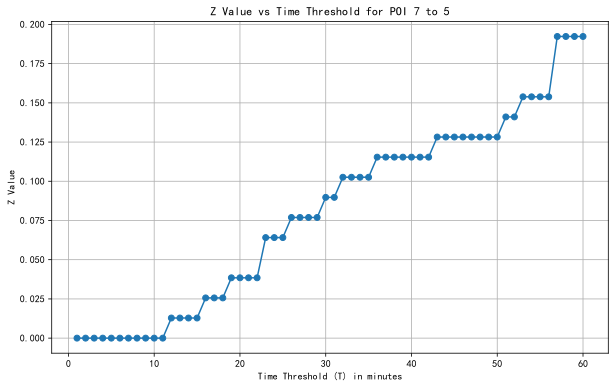

In [23]:
def Z(df, u, i, j, T):
    """ u 是出租车编号，i, j 是POI编号，T是时间阈值"""
    A = df[(df['出租车ID'] == u) & (df['起点（POI）'] == i) & (df['终点（POI）'] == j) & (df['耗时（分钟）'] < T)]
    B = df[(df['出租车ID'] == u) & (df['起点（POI）'] == i) & (df['终点（POI）'] == j)]
    if u == None:
        A = df[(df['起点（POI）'] == i) & (df['终点（POI）'] == j) & (df['耗时（分钟）'] < T)]
        B = df[(df['起点（POI）'] == i) & (df['终点（POI）'] == j)]
    if len(B) == 0:
        return 0
    return len(A) / len(B)

import matplotlib.pyplot as plt

# Define a range of T values
T_values = range(1, 61)  # From 1 to 60 minutes

# Calculate Z for each T value
org, des = 7, 5
Z_values = [Z(loaded_final_result, None, org, des, T) for T in T_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(T_values, Z_values, marker='o')
plt.xlabel('Time Threshold (T) in minutes')
plt.ylabel('Z Value')
plt.title(f'Z Value vs Time Threshold for POI {org} to {des}')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# dask dateframe, .compute()